# Trees

(based on cs109a notebook by Rahul Dave, Kevin Raeder, and Pavlos Protopapas)

We will look here into the practicalities of fitting regression trees, random forests, and boosted trees. These involve out-of-bound estmates and cross-validation, and how you might want to deal with hyperparameters in these models. Along the way we will play a little bit with different loss functions, so that you start thinking about what goes in general into cooking up a machine learning model.

In [21]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn.apionly as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## Dataset

First, the data. We will be attempting to predict the presidential election results (at the county level) from 2016, measured as 'votergap' = (trump - clinton) in percentage points, based mostly on demographic features of those counties.  Let's quick take a peak at the data:

In [22]:
elect_df = pd.read_csv("data/county_level_election.csv")
elect_df.head()

,state,fipscode,county,population,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,cancer,votergap,trump,clinton
0,Colorado,8117,Summit County,27239,15.173,4.918,45.996,2.5,68352,5.4,48.1,8.1,13.1,46.0,46.2,-27.632,31.530,59.162
1,Colorado,8037,Eagle County,53653,30.040,5.169,47.231,3.1,76661,10.1,47.3,9.4,11.8,31.0,47.1,-19.897,36.058,55.955
2,Idaho,16067,Minidoka County,19226,34.070,5.611,49.318,3.7,46332,24.1,11.8,18.3,34.2,80.0,61.8,54.148,71.135,16.987
3,Colorado,8113,San Miguel County,7558,10.154,4.747,46.808,3.7,59603,4.7,54.4,12.4,16.7,5.7,62.6,-44.769,23.892,68.662
4,Utah,49051,Wasatch County,21600,13.244,4.125,48.812,3.4,65207,9.5,34.4,13.9,23.0,257.8,68.3,25.357,50.471,25.114


In [23]:
from sklearn.model_selection import train_test_split

In [24]:
# split 80/20 train-test
Xdf = elect_df[['population','hispanic','minority','female','unemployed','income','nodegree','bachelor','inactivity','obesity','density','cancer']]
response = elect_df['votergap']
Xtraindf, Xtestdf, ytrain, ytest = train_test_split(Xdf, response, test_size=0.2, random_state=1983)


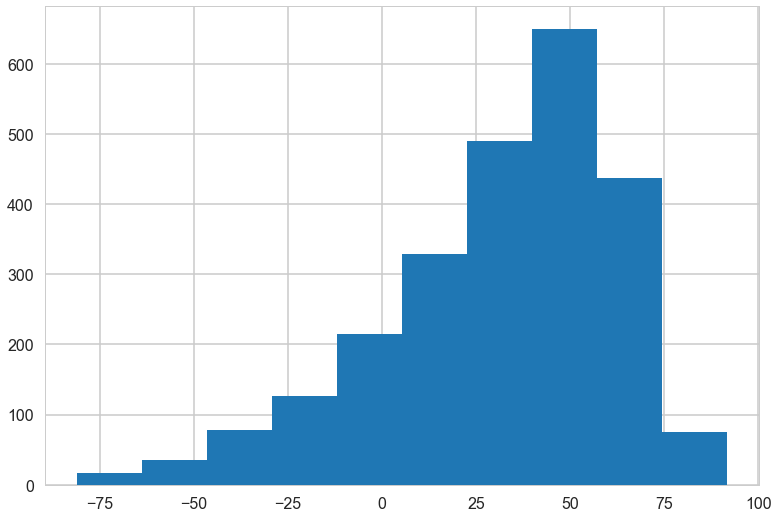

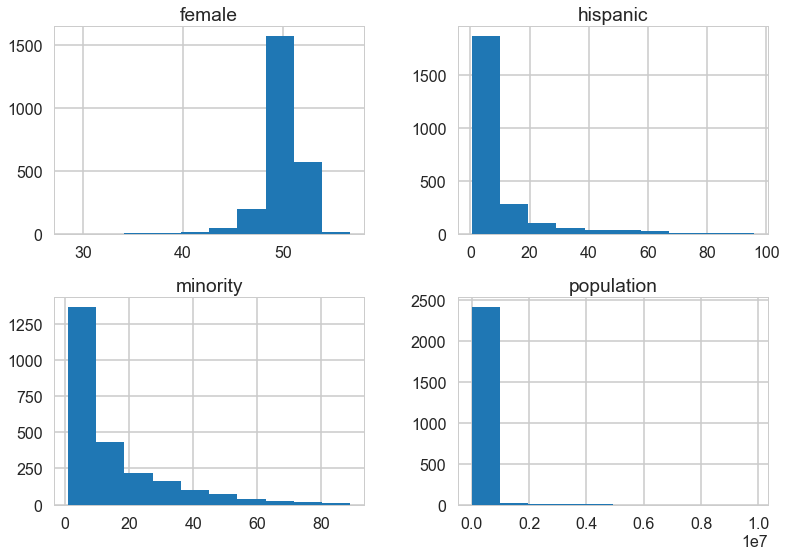

In [25]:
plt.hist(ytrain)
Xtraindf.hist(column=['minority', 'population','hispanic','female']);

## General Trees

We could use a simple Decision Tree regressor to predict votergap. 

This is what you ought to keep in mind about decision trees.

from the docs:
```
max_depth : int or None, optional (default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
min_samples_split : int, float, optional (default=2)
```

- The deeper the tree, the more prone you are to overfitting.
- The smaller `min_samples_split`, the more the overfitting. 
- One may use `min_samples_leaf` instead. More samples per leaf, the higher the bias.

In [26]:
from sklearn.tree import DecisionTreeRegressor
#x = np.arange(0, 2*np.pi, 0.1)
#y = np.sin(x) + 0.1*np.random.normal(size=x.shape[0])
x = Xtraindf['minority'].values
o = np.argsort(x)
x = x[o]
y = ytrain.values
y = y[o]


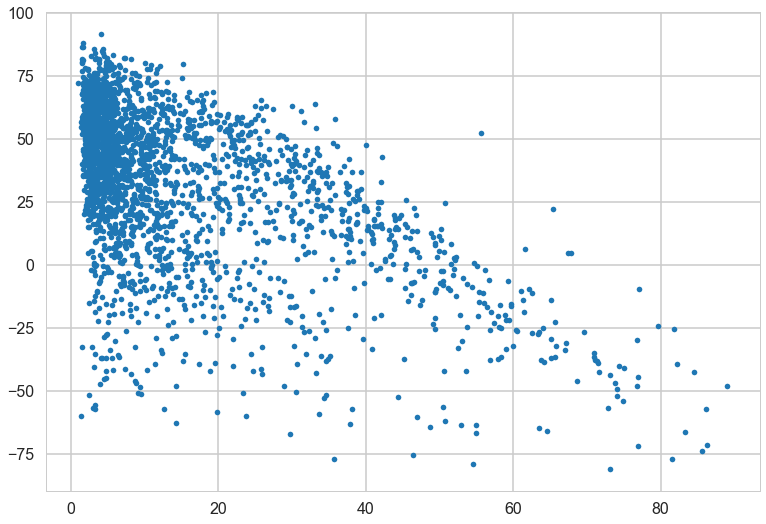

In [27]:
plt.plot(x,y, '.');

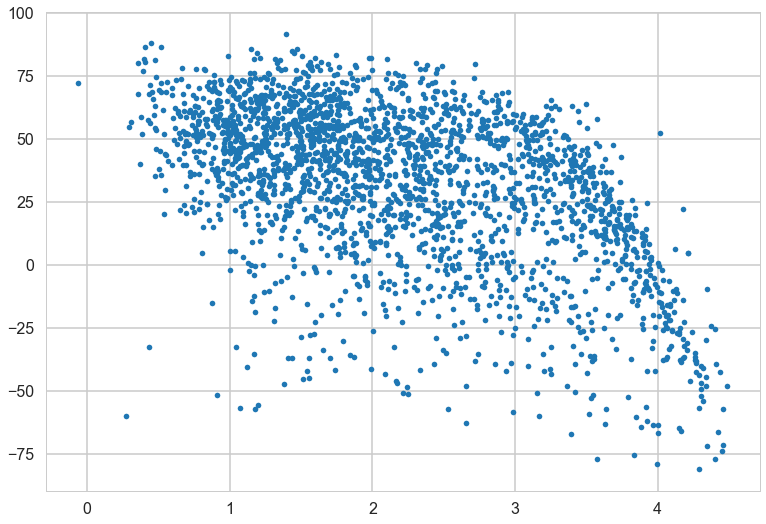

In [28]:
plt.plot(np.log(x),y, '.');

Which of the two versions of 'minority' would be a better choice to use as a predictor for inference?  For prediction?

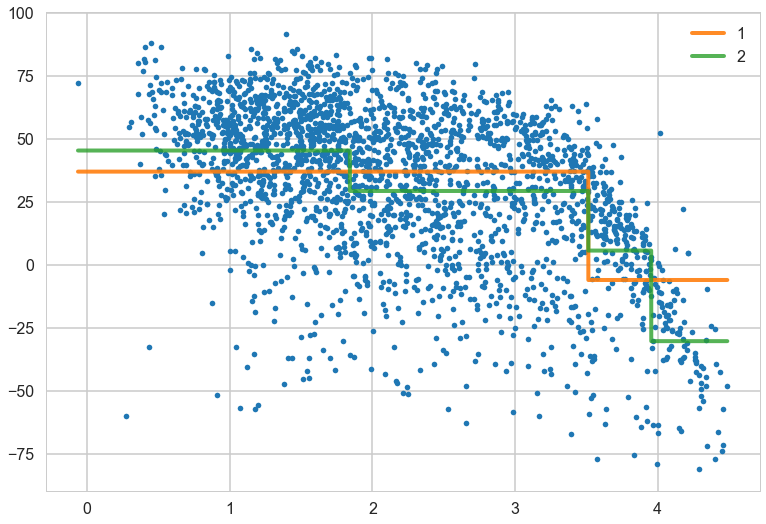

In [29]:
plt.plot(np.log(x),y,'.')
xx = np.log(x).reshape(-1,1)
for i in [1,2]:
    dtree = DecisionTreeRegressor(max_depth=i)
    dtree.fit(xx, y)
    plt.plot(np.log(x), dtree.predict(xx), label=str(i), alpha=1-i/10, lw=4)
plt.legend();

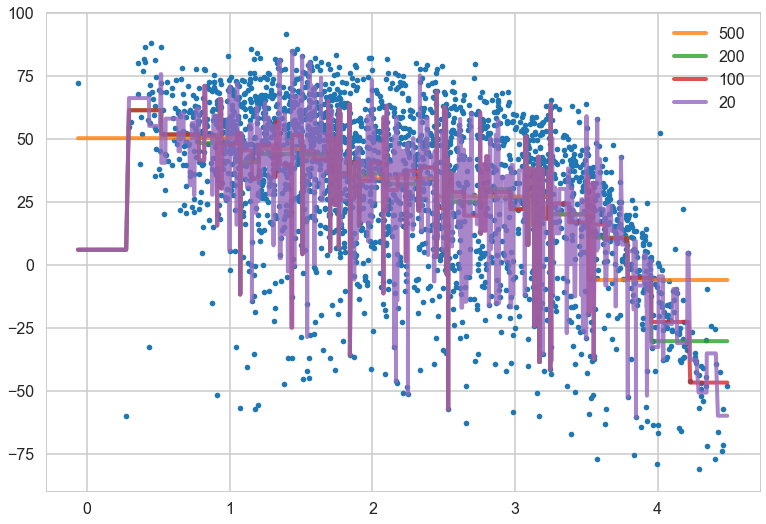

In [30]:
plt.plot(np.log(x),y,'.')
xx = np.log(x).reshape(-1,1)
for i in [500,200,100,20]:
    dtree = DecisionTreeRegressor(min_samples_split=i)
    dtree.fit(xx, y)
    plt.plot(np.log(x), dtree.predict(xx), label=str(i), alpha=0.8, lw=4)
plt.legend();

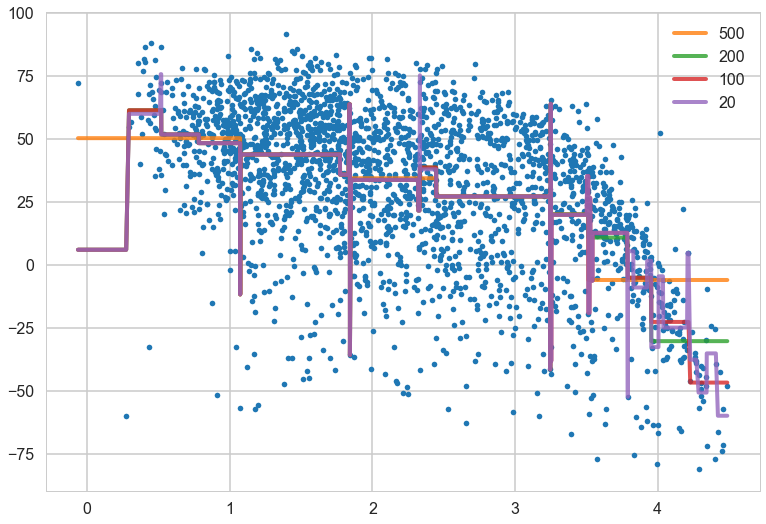

In [31]:
plt.plot(np.log(x),y,'.')
xx = np.log(x).reshape(-1,1)
for i in [500,200,100,20]:
    dtree = DecisionTreeRegressor(max_depth=6, min_samples_split=i)
    dtree.fit(xx, y)
    plt.plot(np.log(x), dtree.predict(xx), label=str(i), alpha=0.8, lw=4)
plt.legend();

In [32]:
#let's also include logminority as a predictor going forward
xtemp = np.log(Xtraindf['minority'].values)
Xtraindf = Xtraindf.assign(logminority = xtemp)
Xtestdf = Xtestdf.assign(logminority = np.log(Xtestdf['minority'].values))
Xtraindf.head()


,population,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,cancer,logminority
1752,26042,1.410,45.917,52.725,11.8,36620,19.9,11.9,27.5,38.2,20.9,239.4,3.826835
2643,30776,6.114,6.549,49.814,4.2,50175,10.4,21.3,25.1,33.5,20.6,285.3,1.879312
1199,19610,50.124,11.044,49.482,3.7,42291,28.9,14.7,29.4,29.5,8.5,215.1,2.401887
918,118179,7.891,8.998,51.151,4.2,40047,14.7,21.0,28.6,34.5,1115.3,201.6,2.197002
2242,35022,1.686,7.722,49.808,5.0,46186,17.3,16.4,27.0,33.0,109.0,262.1,2.044073


# Exercise 1

1. Perform 5-fold cross-validation to determine what the best `max_depth` would be for a single regression tree using the entire 'Xtrain' feature set. 
2. Visualize the results with mean +/- 2 sd's across the validation sets.

In [48]:
from sklearn.model_selection import cross_val_score

depths = list(range(1, 21))
# train_scores = []
# cvmeans = []
# cvstds = []
# cv_scores = []
# your code here

from sklearn.model_selection import GridSearchCV
dtree = DecisionTreeRegressor()
gs = GridSearchCV(dtree, {'max_depth':depths})
gs.fit(Xtraindf, ytrain)

train_scores = gs.cv_results_['mean_train_score']
cvmeans = gs.cv_results_['mean_test_score']
cvstds = gs.cv_results_['std_test_score']
# for depth in depths:
#     dtree = DecisionTreeRegressor(max_depth=depth)
#     # Perform 5-fold cross validation and store results
#     train_scores.append(dtree.fit(Xtraindf, ytrain).score(Xtraindf, ytrain))
#     scores = cross_val_score(estimator=dtree, X=Xtraindf, y=ytrain, cv=5)
#     cvmeans.append(scores.mean())
#     cvstds.append(scores.std())

# cvmeans = np.array(cvmeans)
# cvstds = np.array(cvstds)

//anaconda/envs/py3l/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
//anaconda/envs/py3l/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


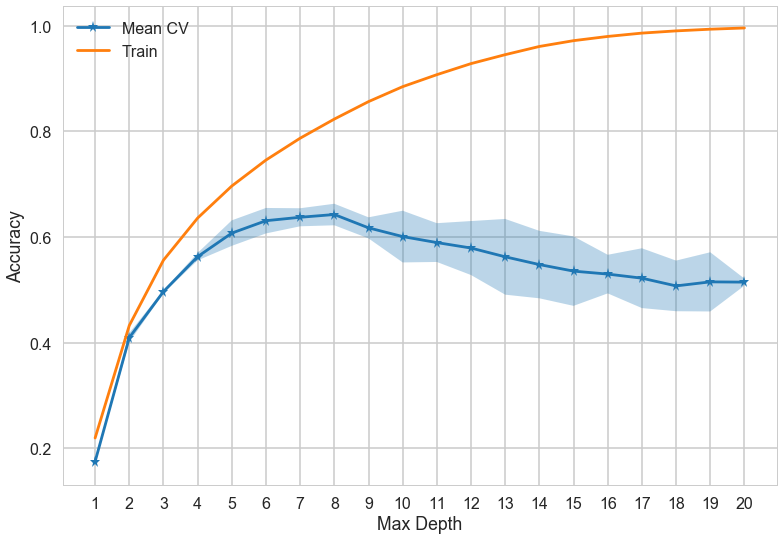

In [49]:
# your code here
# plot means and shade the 2 SD interval
plt.plot(depths, cvmeans, '*-', label="Mean CV")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
ylim = plt.ylim()
plt.plot(depths, train_scores, '-+', label="Train")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.xticks(depths);

Based on the plot above, it's clear that the training $R^2$ increases towards zero as `max_depth` increases, while the test set's $R^2$ maxes out around 62-63% around a `max_depth` of 7-9. Any of those values would be reasonable to choose for a best predictive model.  To prevent overfitting and for parsimony, Iwould choose a `max_depth` of 7.  

In [54]:
dtree = DecisionTreeRegressor(max_depth=6)
print(dtree.fit(Xtraindf, ytrain).score(Xtraindf, ytrain))
dtree.score(Xtestdf, ytest)

0.751676744169196


0.6028469927695509

Still some overfitting though

Trees are very nice models in that they give us feature importances:

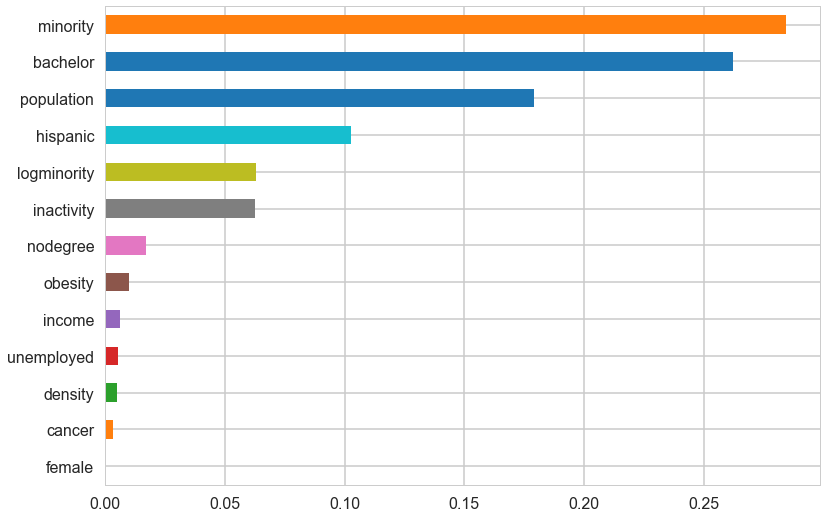

In [55]:
pd.Series(dtree.feature_importances_,index=list(Xtraindf)).sort_values().plot(kind="barh")

Ok with this discussion in mind, lets improve this model by Bagging.

## Bootstrap-Aggregating (called Bagging)

Whats the basic idea?

- A Single Decision tree is likely to overfit.
- So lets introduce replication through Bootstrap sampling.
- **Bagging** uses bootstrap resampling to create different training datasets. This way each training will give us a different tree.
- Added bonus: the left off points can be used to as a natural "validation" set, so no need to leave more data out for cross-validation
- Since we have many trees that we will **average over for prediction**, we can choose a large `max_depth` and we are ok as we will rely on the law of large numbers to shrink this large variance, low bias approach for each individual tree.

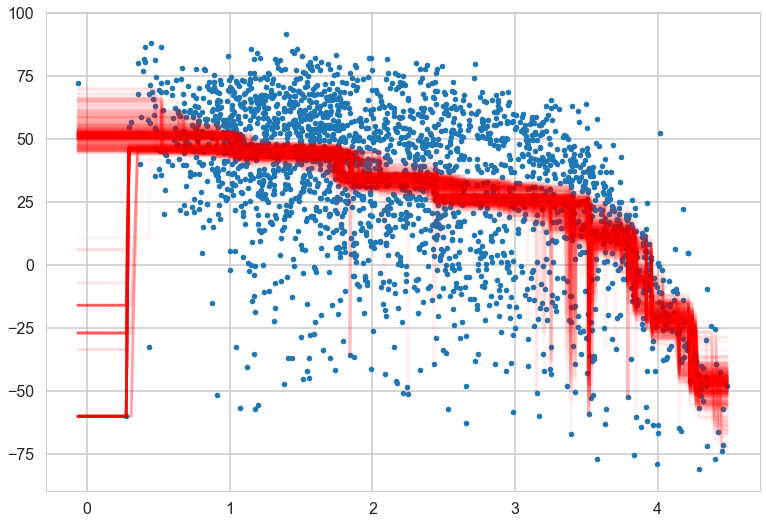

In [36]:
from sklearn.utils import resample

ntrees = 500
estimators = []
R2s = []
yhats_test = np.zeros((Xtestdf.shape[0], ntrees))

plt.plot(np.log(x),y,'.')
for i in range(ntrees):
    simpletree = DecisionTreeRegressor(max_depth=3)
    boot_xx, boot_y = resample(Xtraindf[['logminority']], ytrain)
    estimators = np.append(estimators,simpletree.fit(boot_xx, boot_y))
    R2s = np.append(R2s,simpletree.score(Xtestdf[['logminority']], ytest))
    yhats_test[:,i] = simpletree.predict(Xtestdf[['logminority']])
    plt.plot(np.log(x), simpletree.predict(np.log(x).reshape(-1,1)), 'red', alpha=0.05)

In [37]:
yhats_test.shape

(614, 500)

# Exercise

1. Edit the code below (which is just copied from above) to refit many bagged trees on the entire `Xtrain` feature set (without the plot...lots of predictors now so difficult to plot). 
2. Summarize how each of the separate trees performed (both numerically and visually) using $R^2$ as the metric.  How do they perform on average?
3. Combine the trees into one prediction and evaluate it using $R^2$.
4. Briefly discuss the results.  How will the results above change if 'max_depth' is increased?  What if it is decreased?

Average R-squared score of the individual trees: 0.5400687349135486
R-squared score of the aggregated trees: 0.6380494518141345


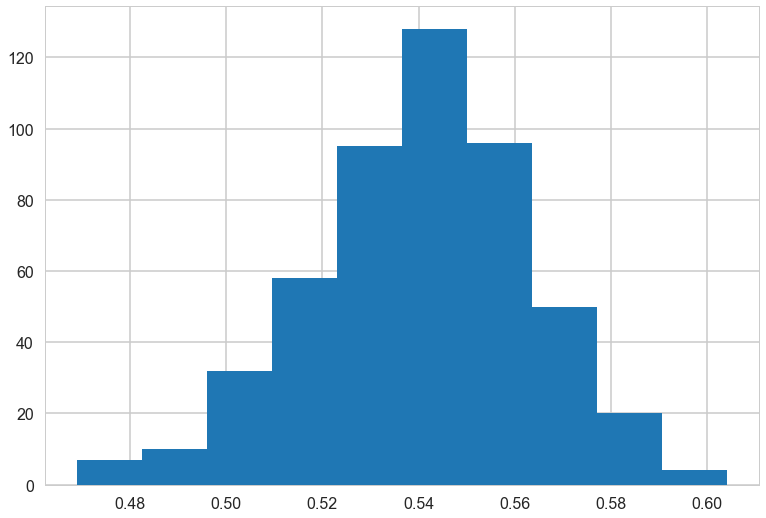

In [38]:
from sklearn.metrics import r2_score


ntrees = 500
estimators = []
R2s = []
yhats_test = np.zeros((Xtestdf.shape[0], ntrees))

# your code here

for i in range(ntrees):
    simpletree = DecisionTreeRegressor(max_depth=4)
    boot_xx, boot_y = resample(Xtraindf, ytrain)
    estimators = np.append(estimators,simpletree.fit(boot_xx, boot_y))
    R2s = np.append(R2s,simpletree.score(Xtestdf, ytest))
    yhats_test[:,i] = simpletree.predict(Xtestdf)

# your code here
#let's look at how the bagging does:
plt.hist(R2s);
print("Average R-squared score of the individual trees:", np.mean(R2s))

bagged_test_predictions = np.mean(yhats_test, axis=1)
print("R-squared score of the aggregated trees:",r2_score(ytest,bagged_test_predictions))


4. Notice that the aggregated results, by averaging the predictions across the 500 different Regression Tree models, scores and $R^2$ in the test set of 64.9% which outperforms all of the separate individual models.  We would expect this to improve further for larger values of `max_depth`, and in fact should imrpove quite a lot.  This Bagging improves the variability of 'high variance' models by leveraging the law of large numbers, but does not improve bias nearly as much.  Essentially, it is an indirect way of 'smoothing' these discretized step function by essentially jittering where those jumps occur.  See the visual above.  

Try a max_depth of 15

Average R-squared score of the individual trees: 0.5093866725531174
R-squared score of the aggregated trees: 0.767132763560343


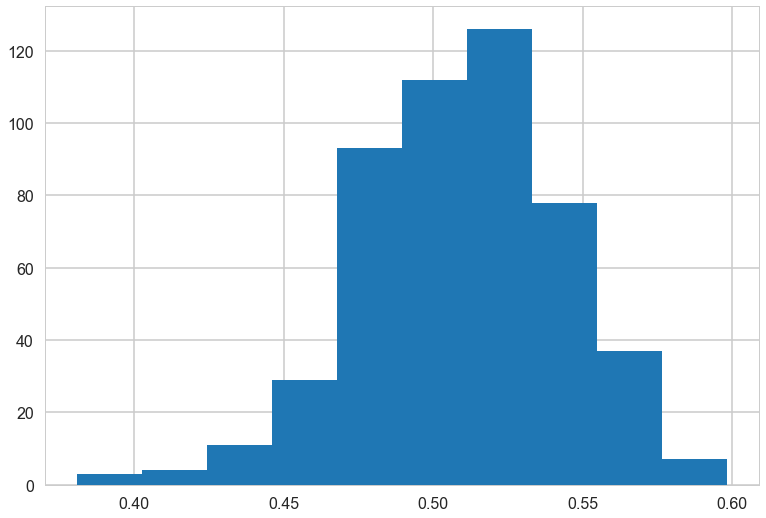

In [39]:
from sklearn.metrics import r2_score


# your code here

ntrees = 500
estimators = []
R2s = []
yhats_test = np.zeros((Xtestdf.shape[0], ntrees))

for i in range(ntrees):
    simpletree = DecisionTreeRegressor(max_depth=15)
    boot_xx, boot_y = resample(Xtraindf, ytrain)
    estimators = np.append(estimators,simpletree.fit(boot_xx, boot_y))
    R2s = np.append(R2s,simpletree.score(Xtestdf, ytest))
    yhats_test[:,i] = simpletree.predict(Xtestdf)

# your code here
#let's look at how the bagging does:
plt.hist(R2s);
print("Average R-squared score of the individual trees:", np.mean(R2s))

bagged_test_predictions = np.mean(yhats_test, axis=1)
print("R-squared score of the aggregated trees:",r2_score(ytest,bagged_test_predictions))

